In [2]:
%matplotlib inline
# %matplotlib notebook
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import logsumexp
from scipy.special import softmax
import numpy.linalg as linalg
from sklearn.cluster import KMeans
from sklearn import metrics
import scipy.sparse as sparse

from collections import Counter


from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
random_seed = 123
rng = np.random.default_rng(random_seed)

# 1 Import Dataset

In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', parser ='auto')

Binarize the Data

In [5]:
X_mnist = np.array(mnist.data) > 0.5 # binary-rise the data
Y_mnist = np.array(mnist.target, dtype ='int')
X_mnist_train = X_mnist[:4000, :] # use the first 4000 images as training data
Y_mnist_train = Y_mnist[:4000]
X_mnist_test = X_mnist[4000:5000, :] # the next 1000 as testing
Y_mnist_test = Y_mnist[4000:5000]

# 2 EM Algorithm

## 2.1 Expectation Step 

Compute responsibility (probability of component generating datapoint) :
$$\begin{align}
\ln r_{ik} &= \ln\pi_k + \ln p(\mathbf{x}^{(i)}| z^{(i)}=k, \{\boldsymbol{\mu}_k\}) + C\\
&=\ln\pi_k + \sum_{d=1}^D x_d^{(i)} \ln\mu_{kd} + (1-x_d^{(i)}) \ln(1-\mu_{kd}) + C
\end{align}$$


Log Likelihood:
$$\ell(\boldsymbol{\pi}, \boldsymbol{\mu}s)=\frac{1}{n}\ln p(\{\mathbf{x}^{(i)}\}_{i=1}^n|\boldsymbol{\pi}, \{\boldsymbol{\mu}_k\}) = \frac{1}{n} \sum_{i=1}^n\ln\left \{ \sum_{k=1}^K \pi_k \cdot p(\mathbf{x}^{(i)}| \boldsymbol{\mu}_k)\right \}$$

In [10]:
def e_step(X, πs, μs, eps=1e-14):
    '''
        πs : k x 1 (priors)
        μs : k x d 
        X  : 500 x d
    '''
    n, D = X.shape
    K = len(πs)
    R = np.zeros((K, n))
    loglik = 0.0

    for k in range(K):
        ll_k = (X @ np.log(μs[k] + eps).T) + ((1 - X) @ np.log(1 - μs[k] + eps).T)

        R[k] = ll_k

    R = np.log(πs + eps) + R.T

    # Compute the norm for each observation 
    log_R_norm = logsumexp(R, axis=1, keepdims=True)

    # Normalize R to sum to 1 across the clusters for each observation 
    R = np.exp(R - log_R_norm)
    
    # Compute average marginal log likelihood 
    loglik = np.sum(log_R_norm) / n        

    return R, loglik

# 2.2 Maximization Step

For $k=1, \ldots, K$:

$$\pi_k = \frac{n_k}{n};\;\; \boldsymbol{\mu}_k = \frac{\sum_{i=1}^n r_{ik} \cdot \mathbf{x}^{(i)}}{n_k},$$


* where $n_k = \sum_{i=1}^n r_{ik}$

In [11]:
def m_step(X, R):
    ## implement here 
    n, d = X.shape # rows are each datapoint, cols are responsibility to each of K clusters

    nk = np.sum(R, axis=0) 
    πs = nk/n
    μs = (R.T @ X)/nk[:, np.newaxis]

    return πs, μs

# 3 EM Algorithm Loop

In [129]:
def em_mixberns(X, K, μs_init=None, tol = 1e-4, maxIters = 100):
	## initilisation
	n, d = X.shape
	
	R = rng.random((n, K))

	# normalize initialization responsibility matrix 
	R /= np.sum(R, axis=1, keepdims=True)

	# perform maximization step
	πs, μs = m_step(X,R)

	if μs_init is not None:
		μs = μs_init

	logLiks = [0.0]

	for i in range(maxIters):
		# E step 
		R, loglik = e_step(X, πs, μs)
		logLiks.append(loglik)

		# M step 
		πs, μs = m_step(X, R)
		zs = np.argmax(R, axis=1)

		# Check for convergence 
		if np.abs(logLiks[-1] - logLiks[-2]) < tol:
			break 
	
	return logLiks, πs, μs, zs, R



In [13]:
def predict(X, πs, μs, eps=1e-14):
    n, D = X.shape
    K = len(πs)
    R = np.zeros((K, n))
    loglik = 0.0

    for k in range(K):
        ll_k = (X @ np.log(μs[k] + eps).T) + ((1 - X) @ np.log(1 - μs[k] + eps).T)
        # full_ll_k = np.log(πs + eps) + ll_k

        R[k] = ll_k

    R = np.log(πs + eps) + R.T

    # Compute the norm for each observation 
    log_R_norm = logsumexp(R, axis=1, keepdims=True)

    # Normalize R to sum to 1 across the clusters for each observation 
    R = np.exp(R - log_R_norm)

    y_preds = np.argmax(R, axis=1)

    return y_preds

# 4 Evaluation

Classify the binary MNIST set

In [130]:
# assume 10 components for digits 0-9
logLiks_em, πs_em, μs_em, zs_em, R_em = em_mixberns(X_mnist_train, 10)

Adjusted rand index:  0.36770923995874816


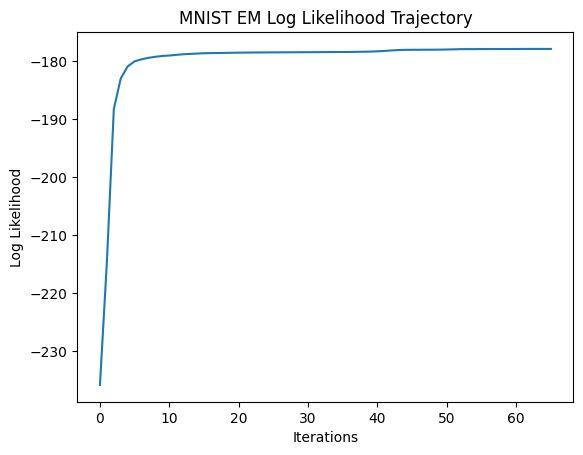

In [131]:
ridx = metrics.adjusted_rand_score(Y_mnist_train, zs_em)

print("Adjusted rand index: ", ridx)

plt.plot(logLiks_em[1:])
plt.title('MNIST EM Log Likelihood Trajectory')
plt.ylabel('Log Likelihood')
plt.xlabel('Iterations')
plt.show()

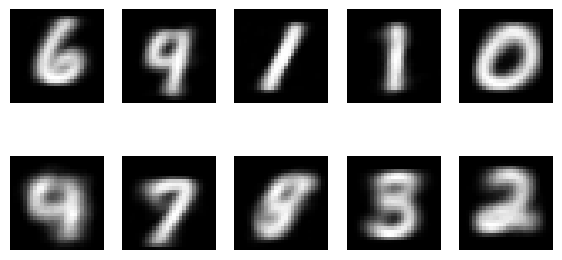

In [65]:
figure = plt.figure(figsize=(7, 3.5))
rows, cols= 2, 5
for k in range(10):
    img = μs_em[k, :].reshape(28, 28)
    figure.add_subplot(rows, cols, k+1)
    # plt.title(k)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()